<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_2/blob/main/CV_mm_faster_rcnn_train_oxford_pet_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MMDetection 설치

In [1]:
# https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 61.6 MB 12.1 MB/s 
     |████████████████████████████████| 190 kB 12.6 MB/s 


In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [1]:
# 런타임->런타임 다시 시작 후 아래 수행. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### Oxford Pet Dataset 다운로드 
image와 annotations을 압축파일로 각각 download 수행. 

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

### 이미지 디렉토리와 annotation 파일 살펴 보기

In [ ]:
!ls -lia ./data/images/Abyss*.jpg

In [ ]:
!ls -lia ./data/images

In [5]:
!cat ./data/annotations/xmls/Abyssinian_1.xml

<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>


In [4]:
import glob
import xml.etree.ElementTree as ET

# annotation xml 파일 파싱해서 bbox정보 추출
def get_bboxes_from_xml_test(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  bbox_names = []
  bboxes = []
  # 파일내에 있는 모든 object Element를 찾음. 
  for obj in root.findall('object'):

    bbox_name = obj.find('name').text
    xmlbox = obj.find('bndbox')
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)

    bbox_names.append(bbox_name)
    bboxes.append([x1, y1, x2, y2])

  return bbox_names, bboxes

get_bboxes_from_xml_test('./data/annotations/xmls/Abyssinian_1.xml')

(['cat'], [[333, 72, 425, 158]])

In [ ]:
!ls -lia ./data/annotations/xmls/Abys*.xml

### train, val image/annotation 메타 파일 보기
* train과 valid 데이터로 나뉠 image와 annotation의 파일명을 가지는 메타 파일
* train과 valid용 meta 파일을 별도로 만듬. 

In [ ]:
!cd ./data/annotations; cat trainval.txt

In [6]:
import pandas as pd

pet_df = pd.read_csv('./data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
pet_df.head()

,img_name,class_id,etc1,etc2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [8]:
pet_df['class_id'].value_counts()

37    100
22    100
34    100
32    100
30    100
28    100
26    100
24    100
20    100
35    100
18    100
16    100
14    100
10    100
6     100
4     100
36    100
1     100
3     100
19    100
31    100
29    100
27    100
25    100
5     100
21    100
17    100
15    100
11    100
9     100
7     100
2     100
33     99
23     96
13     96
8      96
12     93
Name: class_id, dtype: int64

In [12]:
pet_df['img_name'].str.split('_').str[0]

0       Abyssinian
1       Abyssinian
2       Abyssinian
3       Abyssinian
4       Abyssinian
           ...    
3675     yorkshire
3676     yorkshire
3677     yorkshire
3678     yorkshire
3679     yorkshire
Name: img_name, Length: 3680, dtype: object

In [14]:
'Abyssinian_100'.find('_') #

10

In [12]:
pet_df['class_name'] = pet_df['img_name'].apply(lambda x:x[:x.rfind('_')])
pet_df.head()

,img_name,class_id,etc1,etc2,class_name
0,Abyssinian_100,1,1,1,Abyssinian
1,Abyssinian_101,1,1,1,Abyssinian
2,Abyssinian_102,1,1,1,Abyssinian
3,Abyssinian_103,1,1,1,Abyssinian
4,Abyssinian_104,1,1,1,Abyssinian


In [13]:
from sklearn.model_selection import train_test_split

# 기존 데이터 세트를 9:1비율로 학습데이터와 검증데이터로 분리, 각 클래스는 동일하게 9:1 비율을 가진다
train_df, val_df = train_test_split(pet_df, test_size=0.1, stratify=pet_df['class_id'], random_state=2021)

In [14]:
print(train_df['class_id'].value_counts(), val_df['class_id'].value_counts())

37    90
22    90
34    90
32    90
30    90
28    90
26    90
24    90
20    90
35    90
18    90
16    90
14    90
10    90
6     90
4     90
36    90
1     90
3     90
19    90
31    90
29    90
27    90
25    90
5     90
21    90
17    90
15    90
11    90
9     90
7     90
2     90
33    89
23    87
13    86
8     86
12    84
Name: class_id, dtype: int64 37    10
36    10
17    10
16    10
15    10
14    10
13    10
11    10
10    10
9     10
8     10
7     10
6     10
5     10
4     10
3     10
2     10
18    10
19    10
20    10
21    10
35    10
34    10
33    10
32    10
31    10
30    10
29    10
28    10
27    10
26    10
25    10
24    10
22    10
1     10
12     9
23     9
Name: class_id, dtype: int64


In [15]:
train_df = train_df.sort_values(by='img_name')
val_df = val_df.sort_values(by='img_name')

In [16]:
# ann_file로 주어지는 메타파일은 가급적이면 소스데이터의 가장 상단 디렉토리에 저장하는 것이 바람직. 
train_df['img_name'].to_csv('./data/train.txt', sep=' ', header=False, index=False)
val_df['img_name'].to_csv('./data/val.txt', sep=' ', header=False, index=False)

In [17]:
pet_classes_list = pet_df['class_name'].unique().tolist()
print(pet_classes_list)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [ ]:
!echo 'train list #####'; cat ./data/train.txt

In [ ]:
!echo ' valid list ###'; cat ./data/val.txt

### mmdetection의 중립 annotation 포맷 변환
* CLASSES 는 pet_df의 'class_name' 컬럼에 unique 데이터로 지정. class id는 tuple(list)형의 CLASSES의 index값에 따라 설정. 
* ann_file로 입력되는 메타 파일을 읽어서 개별 image정보와 ann 정보를 dict로 생성하여 data_infos list에 입력
* 개별 XML 읽어서 ann 정보를 만드는 것은 get_bboxes_from_xml() 함수 이용. 
* 디버깅용으로 CustomDataset을 만들어서 미리 테스트 하는 방법도 고려. 

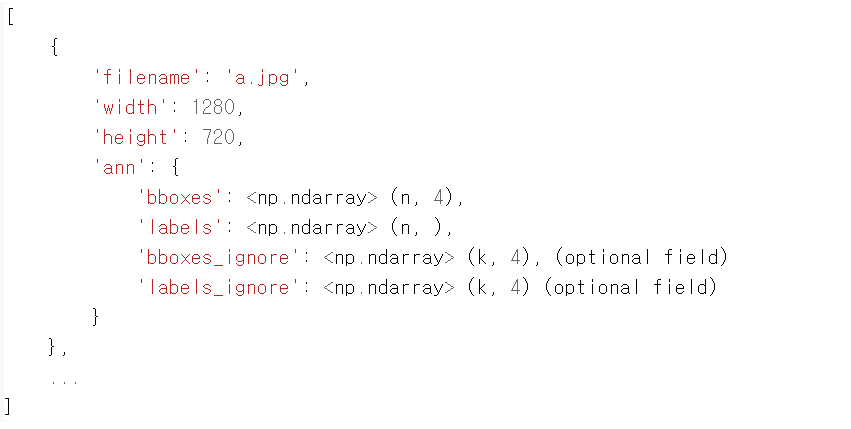

In [19]:
import xml.etree.ElementTree as ET

# 1개의 annotation 파일에서 bbox 정보 추출. 여러개의 object가 있을 경우 이들 object의 name과 bbox 좌표들을 list로 반환.
def get_bboxes_from_xml(anno_dir, xml_file):
  anno_xml_file = osp.join(anno_dir, xml_file)
  tree = ET.parse(anno_xml_file)
  root = tree.getroot()
  bbox_names = []
  bboxes = []

  # 파일내에 있는 모든 object Element를 찾음. 
  for obj in root.findall('object'):
    #obj.find('name').text는 cat 이나 dog을 반환     
    #bbox_name = obj.find('name').text
    # object의 클래스명은 파일명에서 추출. 
    bbox_name = xml_file[:xml_file.rfind('_')]

    xmlbox = obj.find('bndbox')
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)

    bboxes.append([x1, y1, x2, y2])
    bbox_names.append(bbox_name)

  return bbox_names, bboxes

In [20]:
import copy
import os.path as osp

import mmcv
import numpy as np
import cv2

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

import xml.etree.ElementTree as ET

PET_CLASSES = pet_df['class_name'].unique().tolist()

@DATASETS.register_module(force=True)
class PetDataset(CustomDataset):
  CLASSES = PET_CLASSES

  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 
  # 이 self.ann_file이 load_annotations()의 인자로 입력
  def load_annotations(self, ann_file):
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = []

    for image_id in image_list:
      # self.img_prefix는 images 가 입력될 것임. 
      # config의 img_prefix와 data_root가 결합되서 self.img_prefix로 전달
      filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함. 
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename에는 image의 파일명만 들어감(디렉토리는 제외)
      # 영상에는 data_info = {'filename': filename 으로 되어 있으나 filename은 image 파일명만 들어가는게 맞음.
      data_info = {'filename': str(image_id) + '.jpg',
                  'width': width, 'height': height}
      # 개별 annotation XML 파일이 있는 서브 디렉토리의 prefix 변환. 
      label_prefix = self.img_prefix.replace('images', 'annotations')
      
      # 개별 annotation XML 파일을 1개 line 씩 읽어서 list 로드. annotation XML파일이 xmls 밑에 있음에 유의
      anno_xml_file = osp.join(label_prefix, 'xmls/'+str(image_id)+'.xml')
      # 메타 파일에는 이름이 있으나 실제로는 존재하지 않는 XML이 있으므로 이는 제외. 
      if not osp.exists(anno_xml_file):
          continue
      
      # get_bboxes_from_xml() 를 이용하여 개별 XML 파일에 있는 이미지의 모든 bbox 정보를 list 객체로 생성. 
      anno_dir = osp.join(label_prefix, 'xmls')
      bbox_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id)+'.xml')
      #print('#########:', bbox_names)
                  
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []
        
      # bbox별 Object들의 class name을 class id로 매핑. class id는 tuple(list)형의 CLASSES의 index값에 따라 설정
      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        # bbox_name이 CLASSES중에 반드시 하나 있어야 함. 안 그러면 FILTERING 되므로 주의 할것. 
        if bbox_name in cat2label:
            gt_bboxes.append(bbox)
            # gt_labels에는 class id를 입력
            gt_labels.append(cat2label[bbox_name])
        else:
            gt_bboxes_ignore.append(bbox)
            gt_labels_ignore.append(-1)
      
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값을 np.array형태로 bbox의 좌표와 label값으로 생성. 
      data_anno = {
        'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
        'labels': np.array(gt_labels, dtype=np.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)
      #print(data_info)

    return data_infos


In [21]:
''' 디버깅 용도로 CustomDataset을 흉내낸 클래스를 생성하여 다양한 테스트를 수행 가능 '''

import os.path as osp

PET_CLASSES = pet_df['class_name'].unique().tolist()

# 디버깅 용도로 CustomDataset을 흉내낸 클래스 생성. 
class PetDataset_imsi():
  CLASSES = PET_CLASSES

  # 생성자 함수 생성. 
  def __init__(self, data_root, ann_file, img_prefix):
      self.data_root = data_root
      self.ann_file = osp.join(data_root, ann_file)
      self.img_prefix = osp.join(data_root, img_prefix)
      
      self.data_infos = self.load_annotations(self.ann_file)

  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 
  # 이 self.ann_file이 load_annotations()의 인자로 입력
  def load_annotations(self, ann_file):
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = []

    for image_id in image_list:
      # self.img_prefix는 images 가 입력될 것임. 
      filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함. 
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename에는 image의 파일명만 들어감(디렉토리는 제외)
      # 영상에는 data_info = {'filename': filename 으로 되어 있으나 filename은 image 파일명만 들어가는게 맞음. 
      data_info = {'filename': str(image_id) + '.jpg', 
                  'width': width, 'height': height}
      # 개별 annotation XML 파일이 있는 서브 디렉토리의 prefix 변환. 
      label_prefix = self.img_prefix.replace('images', 'annotations')
      
      # 개별 annotation XML 파일을 1개 line 씩 읽어서 list 로드. annotation XML파일이 xmls 밑에 있음에 유의
      anno_xml_file = osp.join(label_prefix, 'xmls/'+str(image_id)+'.xml')
      # 메타 파일에는 이름이 있으나 실제로는 존재하지 않는 XML이 있으므로 이는 제외. 
      if not osp.exists(anno_xml_file):
          continue
      
      # get_bboxes_from_xml() 를 이용하여 개별 XML 파일에 있는 이미지의 모든 bbox 정보를 list 객체로 생성. 
      anno_dir = osp.join(label_prefix, 'xmls')
      bbox_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id)+'.xml')
      #print('#########:', bbox_names)
                  
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []
        
      # bbox별 Object들의 class name을 class id로 매핑. class id는 tuple(list)형의 CLASSES의 index값에 따라 설정
      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        # bbox_name이 CLASSES중에 반드시 하나 있어야 함. 안 그러면 FILTERING 되므로 주의 할것. 
        if bbox_name in cat2label:
            gt_bboxes.append(bbox)
            # gt_labels에는 class id를 입력
            gt_labels.append(cat2label[bbox_name])
        else:
            gt_bboxes_ignore.append(bbox)
            gt_labels_ignore.append(-1)
      
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값을 np.array형태로 bbox의 좌표와 label값으로 생성. 
      data_anno = {
        'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
        'labels': np.array(gt_labels, dtype=np.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)
      #print(data_info)

    return data_infos


In [22]:
# 디버깅 용도로 생성한 클래스를 생성하고 data_infos를 10개만 추출하여 생성된 데이터 확인. 
train_ds = PetDataset_imsi(data_root='/content/data', ann_file='train.txt', img_prefix='images')
print(train_ds.data_infos[:10])

[{'filename': 'Abyssinian_1.jpg', 'width': 600, 'height': 400, 'ann': {'bboxes': array([[333.,  72., 425., 158.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}, {'filename': 'Abyssinian_10.jpg', 'width': 375, 'height': 500, 'ann': {'bboxes': array([[ 72., 105., 288., 291.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}, {'filename': 'Abyssinian_101.jpg', 'width': 450, 'height': 313, 'ann': {'bboxes': array([[ 54.,  36., 319., 235.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}, {'filename': 'Abyssinian_102.jpg', 'width': 500, 'height': 465, 'ann': {'bboxes': array([[ 23.,  27., 325., 320.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dt

### Config를 설정하고 COCO로 Pretrained 된 모델을 Download
* config파일은 faster rcnn resnet 50 backbone 사용. 
* Oxford Pet 데이터는 학습에 시간에 소모 되므로 학습으로 생성된 모델을 Google Drive에 저장

In [23]:
config_file = './mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = './mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [25]:
!cd mmdetection; mkdir checkpoints
!wget -O ./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-12-26 11:31:16--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

./mmdetection/check 100%[===================>] 159.54M  6.95MB/s    in 23s     

2021-12-26 11:31:40 (6.93 MB/s) - ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

In [26]:
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

 파일_001
'Colab Notebooks'
'Computer Organization and Architecture.pdf ( PDFDrive.com ).gdoc'
 CREP-15-CP26023-과제번호-학번.gdoc
 CREP-15-CP26023-HW#4-201524402.gdoc
'CREP-15-CP26023-HW7-20 ㅡ   ㅠㅍ 1524402.gdoc'
 CREP-15-CP26023-HW7-201524402.gdoc
 DaCom_For5_ch7.pptx
 DaCom_For5_ch8.pptx
 hw3_보고서양식.docx
 hw3_보고서양식.gdoc
'INC 리포트 Template의 사본 (1).gdoc'
'INC 리포트 Template의 사본.gdoc'
 이의제기신청서.pdf
 Pdf
 PreviewFiles컴퓨터구조론8판.pdf
 발표.txt
 이전노트북백업파일.zip


In [28]:
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생. 
!mkdir "/mydrive/pet_work_dir"

In [75]:
!nvidia-smi

Sun Dec 26 16:20:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    58W / 149W |  11171MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'PetDataset'
cfg.data_root = '/content/data/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'PetDataset'
cfg.data.train.data_root = '/content/data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PetDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# class의 갯수 수정.
# 37개의 클래스 품종 
cfg.model.roi_head.bbox_head.num_classes = 37
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리로 구글 Drive 설정. 
cfg.work_dir = '/mydrive/pet_work_dir'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 5

# 시간상 epoch를 5번으로 설정
cfg.runner.max_epochs = 5

# 평가 metric 설정. 
cfg.evaluation.metric = 'mAP'
# 5번째 epoch가 끝날때마다 evaluation
# 평가 metric 수행할 epoch interval 설정. 
cfg.evaluation.interval = 5
# 5번째 epoch때마다 checkpoint 저장 
# 학습 iteration시마다 모델을 저장할 epoch interval 설정. 
cfg.checkpoint_config.interval = 5

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨)
cfg.data.samples_per_gpu = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

### Train용 데이터를 생성하고 Oxford Dataset을 학습수행. 
* build_dataset()로 train config 설정에 따른 Train용 dataset 생성. 
* build_detector()로 train과 test config반영하여 model 생성. 
* train_detector()로 model 학습.  

In [31]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

/usr/local/lib/python3.7/dist-packages/mmdet-2.19.1-py3.7.egg/mmdet/datasets/custom.py:178: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [32]:
datasets

[
 PetDataset Train dataset with number of images 3304, and instance counts: 
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | category              | count | category                | count | category                      | count | category            | count | category                        | count |
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | 0 [Abyssinian]        | 89    | 1 [american_bulldog]    | 90    | 2 [american_pit_bull_terrier] | 90    | 3 [basset_hound]    | 90    | 4 [beagle]                      | 90    |
 | 5 [Bengal]            | 89    | 6 [Birman]              | 90    | 7 [Bombay]                    | 86    | 8 [boxer]           | 90    | 9 [British_Shorthair]           | 90    |
 | 10 [chihuahua]

In [ ]:
%cd mmdetection

model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets, cfg, distributed=False, validate=True)

In [ ]:
|!ls -lia /content/data/images/english_cocker_spaniel*

### 학습된 model을 이용하여 inference 수행.
* 현재 memory에서 학습된 model 및 checkpoint 기록된 model을 loading하여 inference 수행.  

/usr/local/lib/python3.7/dist-packages/mmdet-2.19.1-py3.7.egg/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


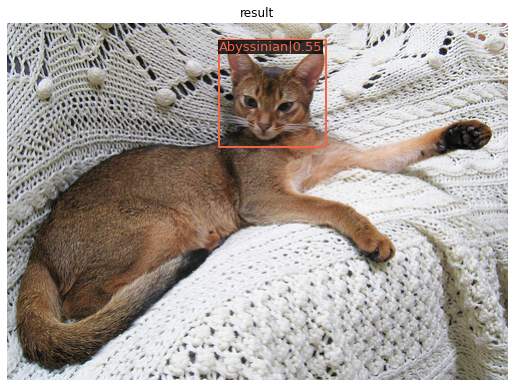

In [35]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [36]:
result

[array([[211.7037   ,  17.68325  , 318.66226  , 124.77704  ,   0.5515088]],
       dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.1934906e+02, 1.9622091e+01, 3.1982001e+02, 1.1701145e+02,
         2.2608249e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.1991580e+02, 1.1453241e+01, 3.0980740e+02, 1.2274485e+02,
         7.2521001e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.21541138e+02, 2.13800449e+01, 3.16155914e+02, 1.20547264e+02,
         2.15282917e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype

In [ ]:
# 아래는 오류를 발생시킵니다. 현재 Customized학습된 모델의 inference시 image file로 인자가 주어졌을때 inference 오류 발생. 
img_path = '/content/data/images/Abyssinian_88.jpg'

model.cfg = cfg

result = inference_detector(model, img_path)
show_result_pyplot(model, img, result, score_thr=0.3)

### Checkpoint 저장된 model 파일을 로딩하고 이를 이용하여 Inference 수행. 

load checkpoint from local path: /mydrive/pet_work_dir/epoch_5.pth


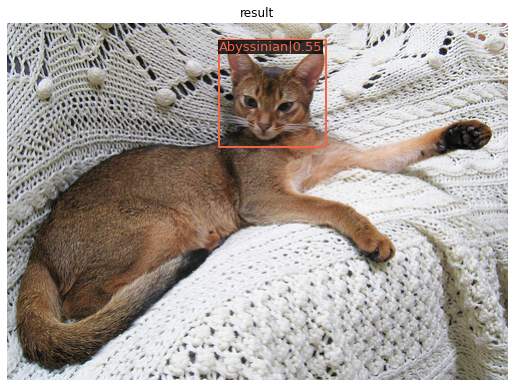

In [37]:
from mmdet.apis import show_result_pyplot

checkpoint_file = '/mydrive/pet_work_dir/epoch_5.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')
# BGR Image 사용 
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')
#model_ckpt.cfg = cfg

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.3)

### 여러개의 image들을 Inference 수행. 
* inference_detector(model, imgs) 에서 인자 imgs는 단일 이미지일 경우 string/array, 여러개의 이미지일 경우 list(string/array)를 입력
* show_result_pyplot(model_ckpt, img, result, score_thr=0.3)는 여러개의 이미지를 한번에 나타내기 어려우므로 별도의 시각화 함수 get_detected_img()를 이용

In [38]:
val_df

,img_name,class_id,etc1,etc2,class_name
0,Abyssinian_100,1,1,1,Abyssinian
21,Abyssinian_11,1,1,1,Abyssinian
24,Abyssinian_122,1,1,1,Abyssinian
29,Abyssinian_127,1,1,1,Abyssinian
44,Abyssinian_140,1,1,1,Abyssinian
...,...,...,...,...,...
3649,yorkshire_terrier_163,37,2,25,yorkshire_terrier
3650,yorkshire_terrier_164,37,2,25,yorkshire_terrier
3651,yorkshire_terrier_165,37,2,25,yorkshire_terrier
3673,yorkshire_terrier_185,37,2,25,yorkshire_terrier


In [39]:
val_df['img_path'] = '/content/data/images/' + val_df['img_name'] + '.jpg'
val_df.head()

,img_name,class_id,etc1,etc2,class_name,img_path
0,Abyssinian_100,1,1,1,Abyssinian,/content/data/images/Abyssinian_100.jpg
21,Abyssinian_11,1,1,1,Abyssinian,/content/data/images/Abyssinian_11.jpg
24,Abyssinian_122,1,1,1,Abyssinian,/content/data/images/Abyssinian_122.jpg
29,Abyssinian_127,1,1,1,Abyssinian,/content/data/images/Abyssinian_127.jpg
44,Abyssinian_140,1,1,1,Abyssinian,/content/data/images/Abyssinian_140.jpg


In [40]:
val_df['img_path'].str.contains('Abyssinian')

0        True
21       True
24       True
29       True
44       True
        ...  
3649    False
3650    False
3651    False
3673    False
3679    False
Name: img_path, Length: 368, dtype: bool

In [41]:
val_df[val_df['img_path'].str.contains('Abyssinian')]['img_path'].values # array 값으로 반환

array(['/content/data/images/Abyssinian_100.jpg',
       '/content/data/images/Abyssinian_11.jpg',
       '/content/data/images/Abyssinian_122.jpg',
       '/content/data/images/Abyssinian_127.jpg',
       '/content/data/images/Abyssinian_140.jpg',
       '/content/data/images/Abyssinian_153.jpg',
       '/content/data/images/Abyssinian_158.jpg',
       '/content/data/images/Abyssinian_182.jpg',
       '/content/data/images/Abyssinian_190.jpg',
       '/content/data/images/Abyssinian_193.jpg'], dtype=object)

In [42]:
val_paths = val_df[val_df['img_path'].str.contains('Abyssinian')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

In [43]:
type(val_imgs), len(val_imgs), val_imgs[0].shape

(list, 10, (500, 394, 3))

In [44]:
# 반환된 results는 개별 원소로 list를 가지는 list임. 
results = inference_detector(model_ckpt, val_imgs)

In [ ]:
len(results), len(results[0]), results

In [55]:
PET_CLASSES = pet_df['class_name'].unique().tolist()
labels_to_names_seq = {i:k for i, k in enumerate(PET_CLASSES)}

# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성. 
def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, result in enumerate(results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(result) == 0:
      continue
    
    # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외. 
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출. 
      left = int(result_filtered[i, 0])
      top = int(result_filtered[i, 1])
      right = int(result_filtered[i, 2])
      bottom = int(result_filtered[i, 3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1)
      if is_print:
        print(caption)

  return draw_img

In [56]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/data/images/Abyssinian_88.jpg')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.3, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환 
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

[array([[211.7037   ,  17.68325  , 318.66226  , 124.77704  ,   0.5515088]],
      dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([[2.1934906e+02, 1.9622091e+01, 3.1982001e+02, 1.1701145e+02,
        2.2608249e-01]], dtype=float32), array([], shape=(0, 5), dtype=float32), array([[2.1991580e+02, 1.1453241e+01, 3.0980740e+02, 1.2274485e+02,
        7.2521001e-02]], dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([[2.21541138e+02, 2.13800449e+01, 3.16155914e+02, 1.20547264e+02,
        2.15282917e-01]], dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], 

Abyssinian: 0.3597
Ragdoll: 0.3822
Abyssinian: 0.5253
Bengal: 0.4537
Abyssinian: 0.3743
Russian_Blue: 0.3103
Abyssinian: 0.4409
Bengal: 0.3358
Abyssinian: 0.5068
Bengal: 0.3187
Bengal: 0.3747
Bombay: 0.6915
Abyssinian: 0.3070
Bengal: 0.3940
Bombay: 0.4618
pomeranian: 0.4027
Ragdoll: 0.3079
Bengal: 0.6383
Bombay: 0.4255


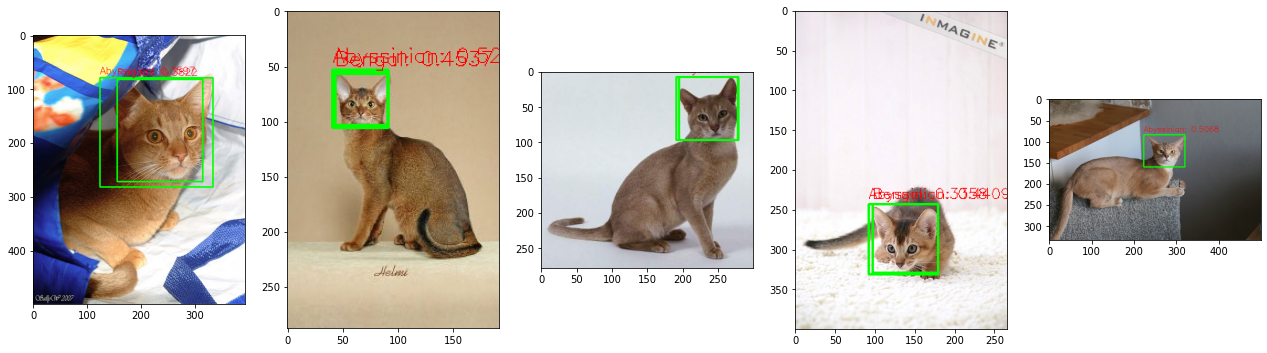

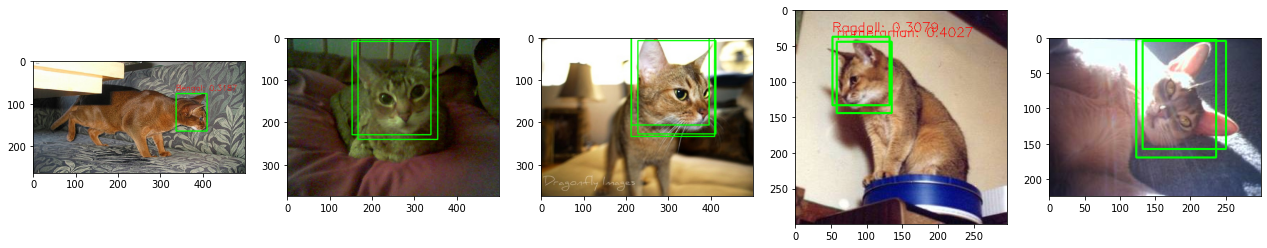

In [52]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

def show_detected_images(model, img_arrays, ncols=5):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
      detected_img = get_detected_img(model, img_arrays[i],  score_threshold=0.3, is_print=True)
      detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
      #detected_img = cv2.resize(detected_img, (328, 328))
      axs[i].imshow(detected_img)

        
show_detected_images(model_ckpt, val_imgs[:5], ncols=5)
show_detected_images(model_ckpt, val_imgs[5:10], ncols=5)

Persian: 0.6625
Ragdoll: 0.3839
Persian: 0.9148
Ragdoll: 0.3443
Persian: 0.8871
Persian: 0.5224
Ragdoll: 0.3815
Sphynx: 0.5961
Persian: 0.7163
Persian: 0.6826
Ragdoll: 0.3930
Persian: 0.6023
Ragdoll: 0.5166
Persian: 0.5516
Persian: 0.4795
Ragdoll: 0.5872
Persian: 0.9066
Persian: 0.6235
Persian: 0.3217


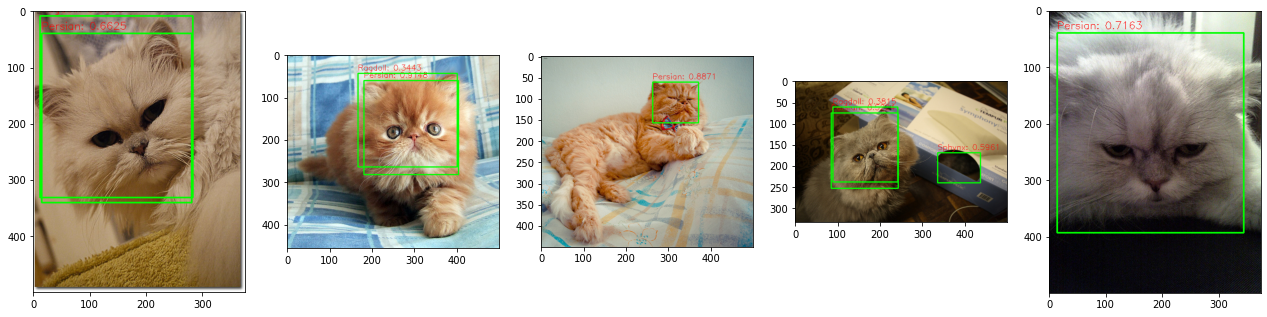

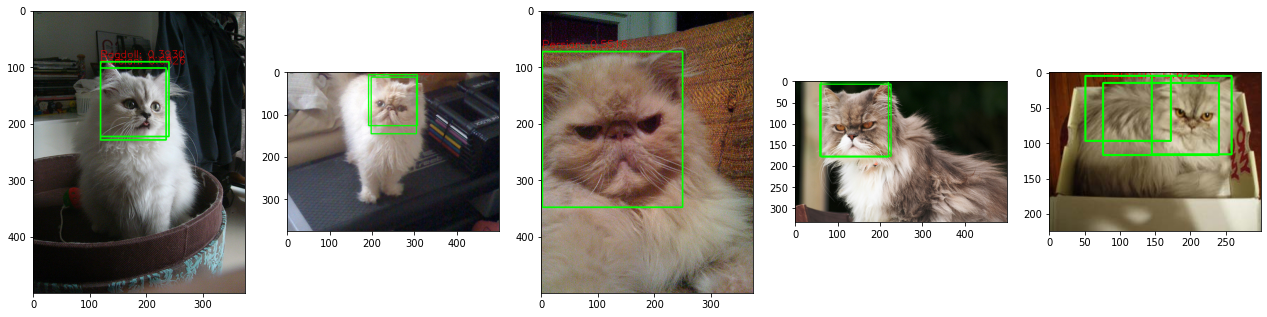

In [53]:
val_paths = val_df[val_df['img_path'].str.contains('Persian')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

show_detected_images(model_ckpt, val_imgs[:5], ncols=5)
show_detected_images(model_ckpt, val_imgs[5:10], ncols=5)